Source Article: 

https://neptune.ai/blog/how-to-implement-customer-churn-prediction
https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset

# Import Libraries

In [1]:
# Load general utilities
# ----------------------
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load sklearn utilities
# ----------------------
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Load classifiers
# ----------------
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# PyTorch Libraries
# -----------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Other Model Packages
# --------------
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTEENN
from catboost import CatBoostClassifier

# Other Libraries
# ---------------
import plotly.express as px

# ignore warning
import warnings
warnings.filterwarnings('ignore')

# Load Telco Dataset

In [2]:
filename = 'telco.csv'
df = pd.read_csv(filename)

In [3]:
df

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,20,0.00,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,0,390.80,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,0,203.94,1910.88,2,Churned,Yes,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,...,0,494.00,2995.07,2,Churned,Yes,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,...,0,234.21,3102.36,2,Churned,Yes,67,2793,Price,Extra data charges
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,Female,30,No,No,No,No,0,United States,California,...,0,1639.44,3039.53,5,Stayed,No,45,5306,NaN,NaN
7039,6840-RESVB,Male,38,No,No,Yes,Yes,2,United States,California,...,0,865.20,2807.47,3,Stayed,No,59,2140,NaN,NaN
7040,2234-XADUH,Female,30,No,No,Yes,Yes,2,United States,California,...,0,2135.52,9453.04,4,Stayed,No,71,5560,NaN,NaN
7041,4801-JZAZL,Female,32,No,No,Yes,Yes,2,United States,California,...,0,0.00,319.21,4,Stayed,No,59,2793,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Under 30                           7043 non-null   object 
 4   Senior Citizen                     7043 non-null   object 
 5   Married                            7043 non-null   object 
 6   Dependents                         7043 non-null   object 
 7   Number of Dependents               7043 non-null   int64  
 8   Country                            7043 non-null   object 
 9   State                              7043 non-null   object 
 10  City                               7043 non-null   object 
 11  Zip Code                           7043 non-null   int64

# Peform Exploratory Data Analysis (EDA)

## Checking For Null Values

In [5]:
# Create a dataframe showing all null values in the df
df_null = pd.DataFrame(
    {'Count':df.isnull().sum(),
     'Total_Loans':len(df),
     'Percent_Null':100 * df.isnull().sum() / len(df)}
)

# Subset the df_null dataframe to only see columns that 
# contain null values
df_null[df_null['Count'] > 0]

,Count,Total_Loans,Percent_Null
Offer,3877,7043,55.047565
Internet Type,1526,7043,21.666903
Churn Category,5174,7043,73.463013
Churn Reason,5174,7043,73.463013


#### Offer NaN Values

Offer contains 55% Null values. This simply means, that there were no offers offered or promotions handed out to these 55% of the customer base within this dataset. Therefore, it would be appropriate to make the NaN values as "No Offer". 

In [6]:
df['Offer'].value_counts(dropna=False)

Offer
NaN        3877
Offer B     824
Offer E     805
Offer D     602
Offer A     520
Offer C     415
Name: count, dtype: int64

In [7]:
df['Offer'].fillna('No Offer', inplace=True)

In [8]:
df['Offer'].value_counts(dropna=False)

Offer
No Offer    3877
Offer B      824
Offer E      805
Offer D      602
Offer A      520
Offer C      415
Name: count, dtype: int64

#### Internet Type NaN Values

The NaN values within the Internet Type are due to the customers who do not have internet. Therefore, we will replace NaN with "No Internet". 

In [9]:
df['Internet Type'].value_counts(dropna=False)

Internet Type
Fiber Optic    3035
DSL            1652
NaN            1526
Cable           830
Name: count, dtype: int64

In [10]:
df['Internet Type'].fillna('No Internet', inplace=True)

In [11]:
df['Internet Type'].value_counts(dropna=False)

Internet Type
Fiber Optic    3035
DSL            1652
No Internet    1526
Cable           830
Name: count, dtype: int64

#### Churn Category NaN Values

The NaN values in this column represent customers who did not churn. Therefore, we will replace the NaN values with "No Churn".

In [12]:
df['Churn Category'].value_counts(dropna=False)

Churn Category
NaN                5174
Competitor          841
Attitude            314
Dissatisfaction     303
Price               211
Other               200
Name: count, dtype: int64

In [13]:
df['Churn Category'].fillna('No Churn', inplace=True)

In [14]:
df['Churn Category'].value_counts(dropna=False)

Churn Category
No Churn           5174
Competitor          841
Attitude            314
Dissatisfaction     303
Price               211
Other               200
Name: count, dtype: int64

#### Churn Reason NaN Values

The NaN values in this column represent customers who did not churn. Therefore, we will replace the NaN values with "No Churn".

In [15]:
df['Churn Reason'].value_counts(dropna=False)

Churn Reason
NaN                                          5174
Competitor had better devices                 313
Competitor made better offer                  311
Attitude of support person                    220
Don't know                                    130
Competitor offered more data                  117
Competitor offered higher download speeds     100
Attitude of service provider                   94
Price too high                                 78
Product dissatisfaction                        77
Network reliability                            72
Long distance charges                          64
Service dissatisfaction                        63
Moved                                          46
Extra data charges                             39
Limited range of services                      37
Poor expertise of online support               31
Lack of affordable download/upload speed       30
Lack of self-service on Website                29
Poor expertise of phone support      

In [16]:
df['Churn Reason'].fillna('No Churn', inplace=True)

In [17]:
df['Churn Reason'].value_counts(dropna=False)

Churn Reason
No Churn                                     5174
Competitor had better devices                 313
Competitor made better offer                  311
Attitude of support person                    220
Don't know                                    130
Competitor offered more data                  117
Competitor offered higher download speeds     100
Attitude of service provider                   94
Price too high                                 78
Product dissatisfaction                        77
Network reliability                            72
Long distance charges                          64
Service dissatisfaction                        63
Moved                                          46
Extra data charges                             39
Limited range of services                      37
Poor expertise of online support               31
Lack of affordable download/upload speed       30
Lack of self-service on Website                29
Poor expertise of phone support      

#### Validate that our whole dataset does not contain any Null values

In [18]:
# Create a dataframe showing all null values in the df
df_null = pd.DataFrame(
    {'Count':df.isnull().sum(),
     'Total_Loans':len(df),
     'Percent_Null':100 * df.isnull().sum() / len(df)}
)

# Subset the df_null dataframe to only see columns that 
# contain null values
df_null[df_null['Count'] > 0]

,Count,Total_Loans,Percent_Null


## Feature Engineering

We'll inspect each feature individually, and do the following:

- Drop the feature if it is not useful for predicting customer churn.
- View summary statistics and visualize the data, plotting against the churn status.
- Modify the feature to make it useful for modeling, if necessary.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Under 30                           7043 non-null   object 
 4   Senior Citizen                     7043 non-null   object 
 5   Married                            7043 non-null   object 
 6   Dependents                         7043 non-null   object 
 7   Number of Dependents               7043 non-null   int64  
 8   Country                            7043 non-null   object 
 9   State                              7043 non-null   object 
 10  City                               7043 non-null   object 
 11  Zip Code                           7043 non-null   int64

A majority of the code has already been written from a previous dataset using Churn instead of Churn Label. I will change this column name to ensure my code works consistently without needing to change every string for the column name. 

In [20]:
df['Churn'] = df['Churn Label']
df.drop(columns='Churn Label', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Under 30                           7043 non-null   object 
 4   Senior Citizen                     7043 non-null   object 
 5   Married                            7043 non-null   object 
 6   Dependents                         7043 non-null   object 
 7   Number of Dependents               7043 non-null   int64  
 8   Country                            7043 non-null   object 
 9   State                              7043 non-null   object 
 10  City                               7043 non-null   object 
 11  Zip Code                           7043 non-null   int64

In [21]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the Churn status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without churn status
    if continuous:
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with churn status
    if continuous:
        sns.boxplot(x=col_name, y='Churn', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Churn Status')
    else:
        churn_rates = df.groupby(col_name)['Churn'].value_counts(normalize=True).loc[:, 'Yes']
        sns.barplot(x=churn_rates.index, y=churn_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Churn Rate')
        ax2.set_title('Churn Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

#### 0. Customer ID

This is just a unique identifier for each customer and will be excluded from this predictive model. 

In [22]:
df.drop(columns='Customer ID', inplace=True)

#### 1. Gender

- Yes: Indicates that the customer is a Male
- No: Indicates that the customer is a Female

In [23]:
df['Gender'].value_counts(normalize=False)

Gender
Male      3555
Female    3488
Name: count, dtype: int64

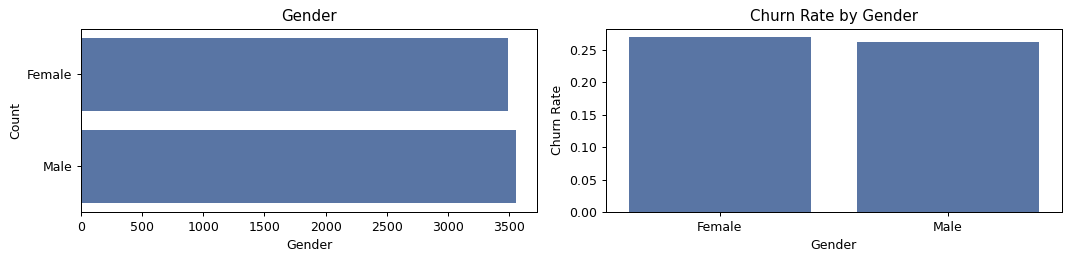

In [24]:
plot_var(col_name='Gender', full_name='Gender', continuous=False)

In [25]:
df.groupby('Gender')['Churn'].value_counts(normalize=True)

Gender  Churn
Female  No       0.730791
        Yes      0.269209
Male    No       0.738397
        Yes      0.261603
Name: proportion, dtype: float64

It appears that the gender column is fairly balanced among genders. I don't see any disparities that exist.

#### 2. Age

Represents the age of the customer

In [26]:
df['Age'].describe()

count    7043.000000
mean       46.509726
std        16.750352
min        19.000000
25%        32.000000
50%        46.000000
75%        60.000000
max        80.000000
Name: Age, dtype: float64

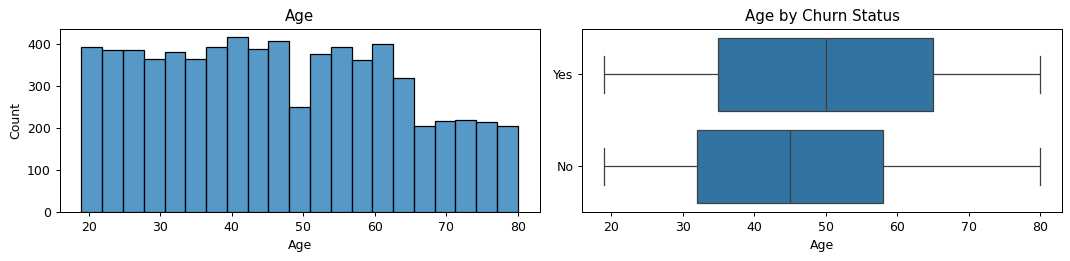

In [27]:
plot_var('Age', 'Age', True)

It appears that customers who are older generally tend to churn more often. 

#### 3. Under 30

- Yes: Represents customers who are younger than 30 years old
- No: Represents customers who are older than 30 years old

In [28]:
df['Under 30'].value_counts()

Under 30
No     5642
Yes    1401
Name: count, dtype: int64

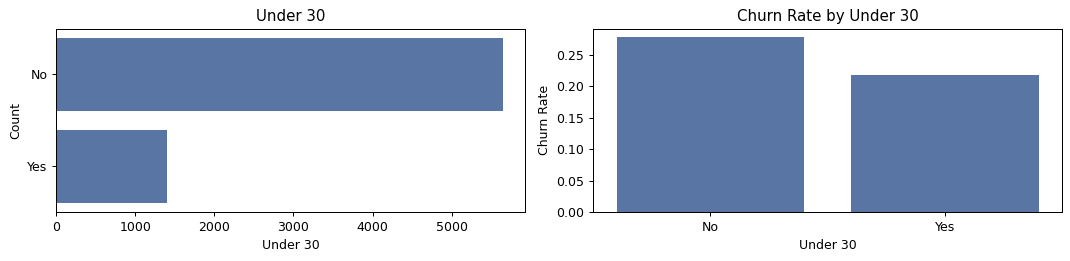

In [29]:
plot_var('Under 30', 'Under 30', False)

This feature displays that people younger than 30 contribute more to the churn rate. 

#### 4. SeniorCitizen

- No: Represents that customer is not a senior citizen
- Yes: Represents that customer is a senior citizen

In [30]:
df['Senior Citizen'].value_counts(normalize=True)

Senior Citizen
No     0.837853
Yes    0.162147
Name: proportion, dtype: float64

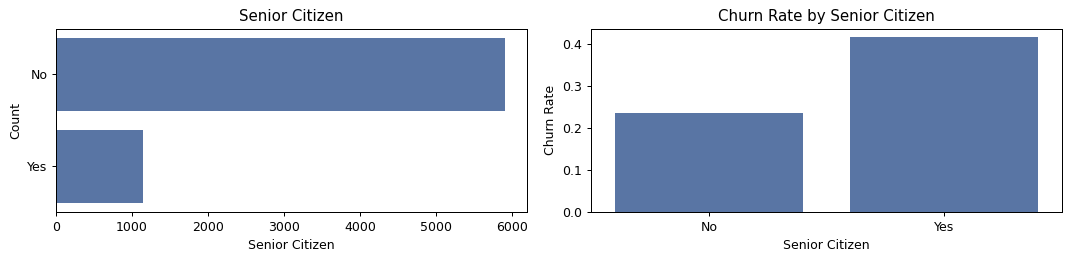

In [31]:
plot_var(col_name='Senior Citizen', full_name="Senior Citizen", continuous=False)

In [32]:
df.groupby('Senior Citizen')['Churn'].value_counts(normalize=True)

Senior Citizen  Churn
No              No       0.763938
                Yes      0.236062
Yes             No       0.583187
                Yes      0.416813
Name: proportion, dtype: float64

The SeniorCitizen frequencies are quite imbalanced which may cause our models to predict better churn rates on non senior citizen. 

**Note**: The churn rate also increases with Senior Citizens; however, this could simply be due to less sample size causing the senior citizens that do cancel to take up a larger amount proportionally to the whole. 

#### 5. Married

- Yes: Represents that the customer is married
- No: Represents that the customer is not married

In [33]:
df['Married'].value_counts()

Married
No     3641
Yes    3402
Name: count, dtype: int64

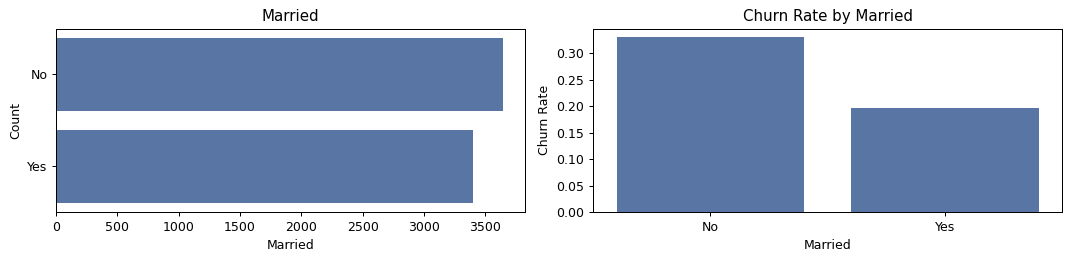

In [34]:
plot_var('Married', 'Married', False)

In [35]:
df.groupby('Married')['Churn'].value_counts(normalize=True)

Married  Churn
No       No       0.670420
         Yes      0.329580
Yes      No       0.803351
         Yes      0.196649
Name: proportion, dtype: float64

We can see that those who are single tend to churn more often than those without a partner.

#### 6. Dependents

- Yes: Represents customers who have dependents
- No: Represents customers who do not have dependents

In [36]:
df['Dependents'].value_counts()

Dependents
No     5416
Yes    1627
Name: count, dtype: int64

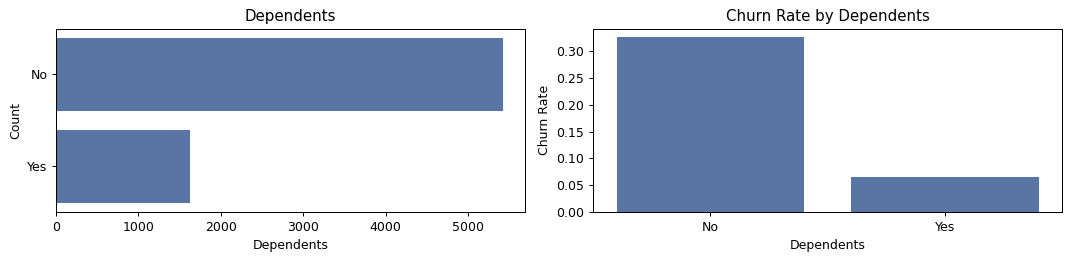

In [37]:
plot_var('Dependents', 'Dependents', False)

In [38]:
df.groupby('Dependents')['Churn'].value_counts(normalize=True)

Dependents  Churn
No          No       0.674483
            Yes      0.325517
Yes         No       0.934849
            Yes      0.065151
Name: proportion, dtype: float64

We can see that churn rates tend to be higher for customers without dependents. 

#### 7. Number of Dependents

Represents the number of dependents the customer has. It is currently listed as an integer value where we want this be categorical. 

In [39]:
df['Number of Dependents'] = df['Number of Dependents'].astype('category')

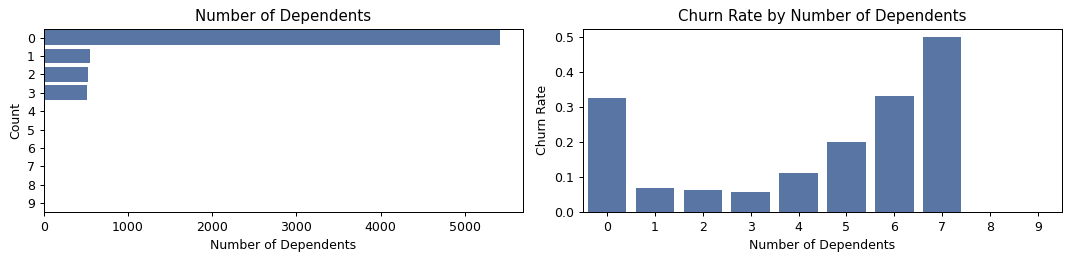

In [40]:
plot_var('Number of Dependents', 'Number of Dependents', False)

In [41]:
df['Number of Dependents'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: Number of Dependents
Non-Null Count  Dtype   
--------------  -----   
7043 non-null   category
dtypes: category(1)
memory usage: 7.4 KB


#### 8. Country

Represents what country the customer resides in. 

In [42]:
df['Country'].value_counts()

Country
United States    7043
Name: count, dtype: int64

No furhter analysis needed. All customers reside in the United States. Therefore, this feature may be dropped from the dataset.

In [43]:
df.drop(columns = 'Country', inplace=True)

#### 9. State

Represents what state the customer resides in.

In [44]:
df['State'].value_counts()

State
California    7043
Name: count, dtype: int64

No further analysis needed. All customers reside in California. Therefore, this feature may be dropped from the dataset.

In [45]:
df.drop(columns = 'State', inplace=True)

#### 10. City

Represents which city the customer lives in.

In [46]:
df['City'].value_counts()

City
Los Angeles         293
San Diego           285
San Jose            112
Sacramento          108
San Francisco       104
                   ... 
Jacumba               2
South Lake Tahoe      2
Johannesburg          2
Eldridge              2
Holtville             2
Name: count, Length: 1106, dtype: int64

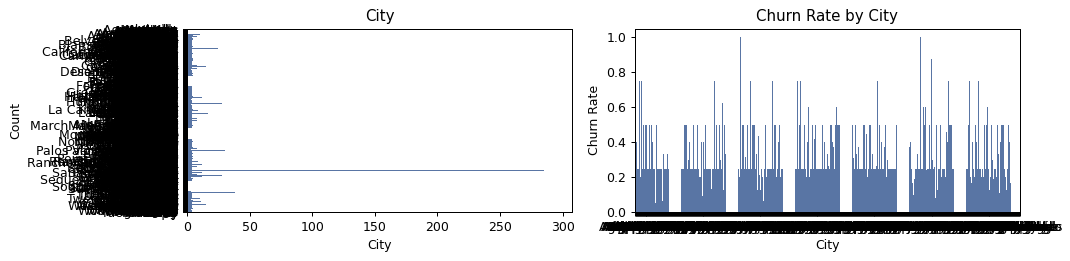

In [47]:
plot_var('City', 'City', False)

The above charts look really messy which means that there are a lot of cities that exist in this dataset. This feature may be pretty important for the predictive model. 

#### 11. Zip Code

This feature is unnecessary as we already have the city information. That will be enough for prediction. 

In [48]:
df.drop(columns='Zip Code', inplace=True)

#### 12. Latitude

This feature is unnecessary as we already have the city information. That will be enough for prediction. 

In [49]:
df.drop(columns='Latitude', inplace=True)

#### 13. Longitude

This feature is unnecessary as we already have the city information. That will be enough for prediction. 

In [50]:
df.drop(columns='Longitude', inplace=True)

#### 14. Population

This represents the population size of the location where the customer resides. Low values represent sparse populations and large values represent those that live in denely populated areas. 

In [51]:
df['Population'].describe()

count      7043.000000
mean      22139.603294
std       21152.392837
min          11.000000
25%        2344.000000
50%       17554.000000
75%       36125.000000
max      105285.000000
Name: Population, dtype: float64

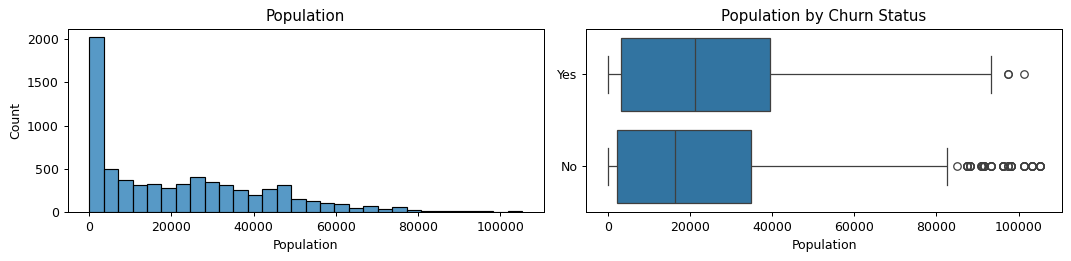

In [52]:
plot_var('Population', 'Population', True)

#### 15. Quarter

This represents the quarter that the customer was onboarded. 

In [53]:
df['Quarter'].value_counts()

Quarter
Q3    7043
Name: count, dtype: int64

This data is not necessary for prediction as all values in this column is Q3. 

In [54]:
df.drop(columns='Quarter', inplace=True)

#### 16. Referred a Friend

- Yes: Represents a customer who referred a friend to Telco
- No: Represents a customer who did not refer a friend to Telco

In [55]:
df['Referred a Friend'].value_counts()

Referred a Friend
No     3821
Yes    3222
Name: count, dtype: int64

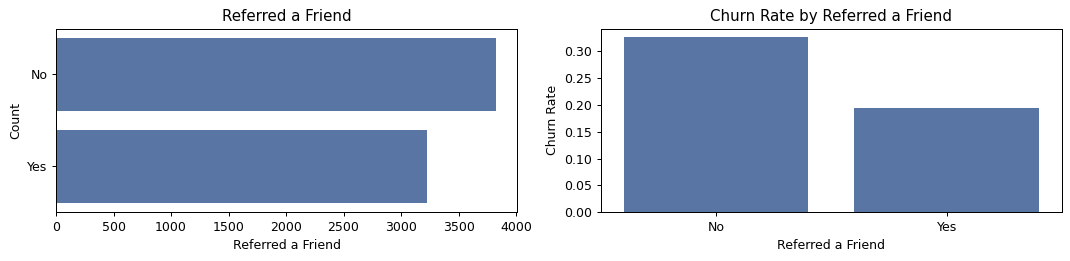

In [56]:
plot_var('Referred a Friend', 'Referred a Friend', False)

#### 17. Number of Referrals 

This represents the number of referrals that customers made. 

In [57]:
df['Number of Referrals'] = df['Number of Referrals'].astype('category')

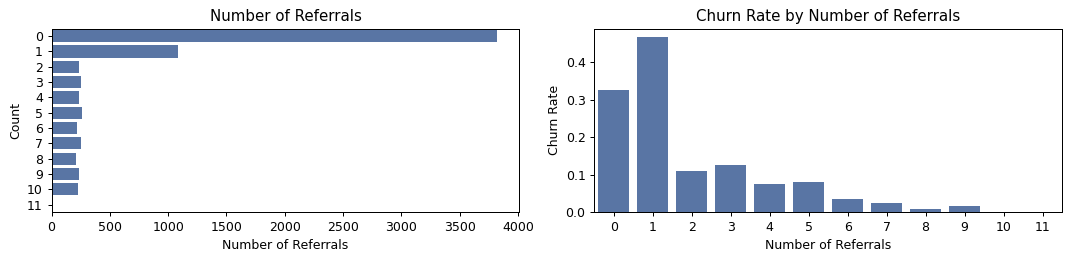

In [58]:
plot_var('Number of Referrals', 'Number of Referrals', False)

#### 18. Tenure in Months 

Number of months the customer has stayed with the company

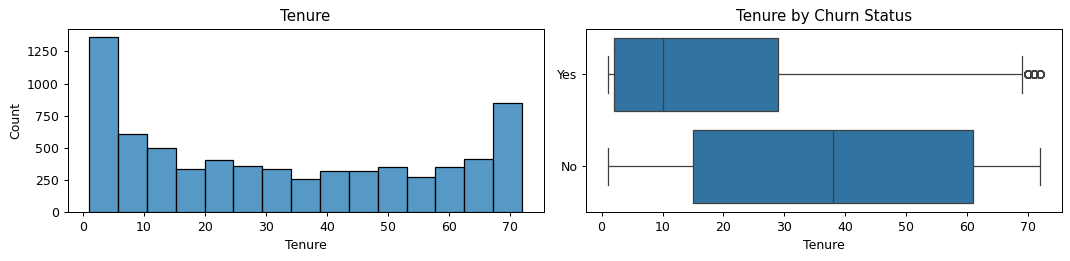

In [59]:
plot_var('Tenure in Months', 'Tenure', True)

In [60]:
df.groupby('Churn')['Tenure in Months'].describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,37.591225,24.085029,1.0,15.0,38.0,61.0,72.0
Yes,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0


As can be seen from the above charts, customers that have stayed with Telco longer tend not to churn. This is very intuitive and the data proves this. 

#### 19. Offer

This represents the type of offer customers received. 

In [61]:
df['Offer'].value_counts()

Offer
No Offer    3877
Offer B      824
Offer E      805
Offer D      602
Offer A      520
Offer C      415
Name: count, dtype: int64

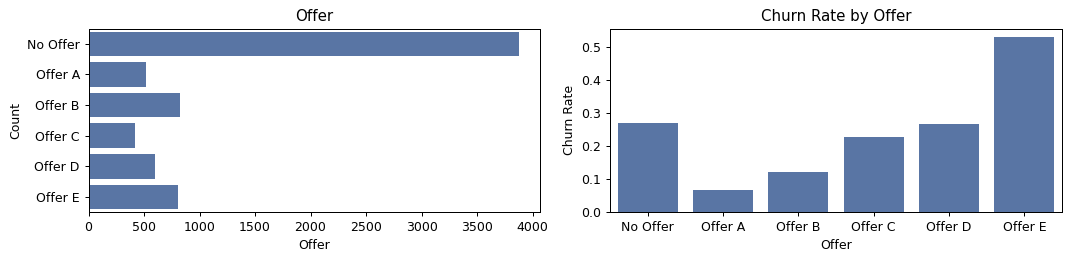

In [62]:
plot_var('Offer', 'Offer', False)

#### 20. Phone Service

- Yes: Represents that the customer has a phone service.
- No: Represents that the customer does not have a phone service. 

In [63]:
df['Phone Service'].value_counts()

Phone Service
Yes    6361
No      682
Name: count, dtype: int64

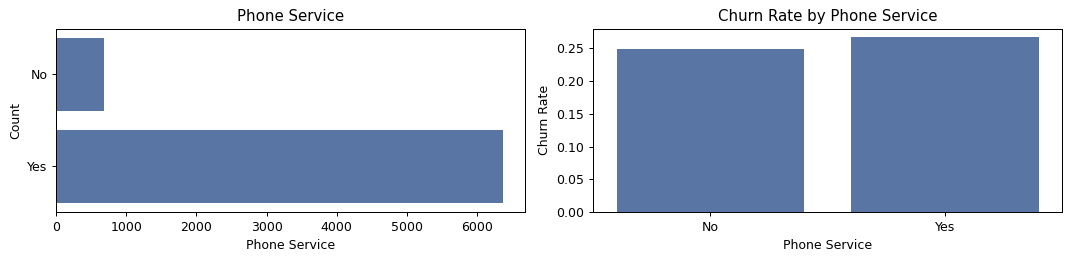

In [64]:
plot_var('Phone Service', 'Phone Service', False)

In [65]:
df.groupby('Phone Service')['Churn'].value_counts(normalize=True)

Phone Service  Churn
No             No       0.750733
               Yes      0.249267
Yes            No       0.732904
               Yes      0.267096
Name: proportion, dtype: float64

We can see that the churn rate by phone service is pretty equal. This means that, at first glance, this doesn't necessarily help us predict churn. 

**Note**: The frequency of customers that have a phone service far outweigh those that do. This is a really imbalanced feature. 

#### 21. Avg Monthly Long Distance Charges

This represents the Avg Monthly charges that this customer has incurred in USD ($)

In [66]:
df['Avg Monthly Long Distance Charges'].describe()

count    7043.000000
mean       22.958954
std        15.448113
min         0.000000
25%         9.210000
50%        22.890000
75%        36.395000
max        49.990000
Name: Avg Monthly Long Distance Charges, dtype: float64

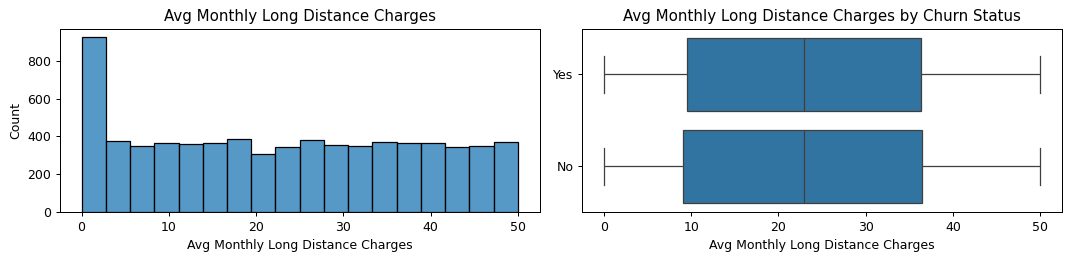

In [67]:
plot_var('Avg Monthly Long Distance Charges', 'Avg Monthly Long Distance Charges', True)

In [68]:
df.groupby('Churn')['Avg Monthly Long Distance Charges'].describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,22.883572,15.462845,0.0,9.1,22.89,36.4175,49.99
Yes,1869.0,23.167635,15.409464,0.0,9.5,22.88,36.3600,49.98


We can see that it appears the distribution of churn vs no churn is almost the same when comparing average monthly long distance charges. 

#### 22. Multiple Lines

- Yes: Represents that customer has multiple lines
- No: Represents that the customer does not have multiple lines

In [69]:
df['Multiple Lines'].value_counts()

Multiple Lines
No     4072
Yes    2971
Name: count, dtype: int64

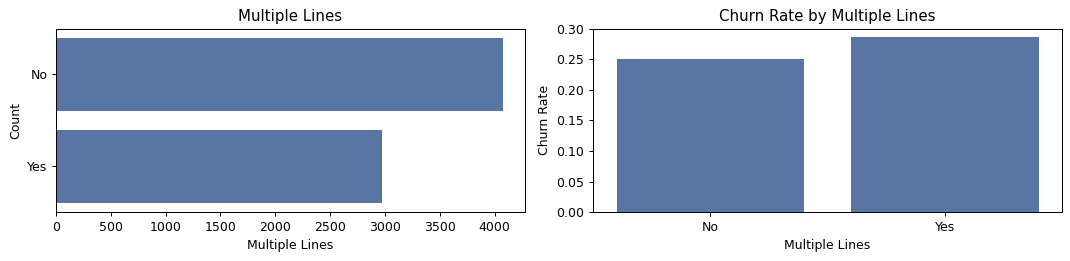

In [70]:
plot_var('Multiple Lines', 'Multiple Lines', False)

#### 23. Internet Service

- Yes: Represnts customers who have Internet Service
- No: Represents customers who do not use the Internet Service

In [71]:
df['Internet Service'].value_counts()

Internet Service
Yes    5517
No     1526
Name: count, dtype: int64

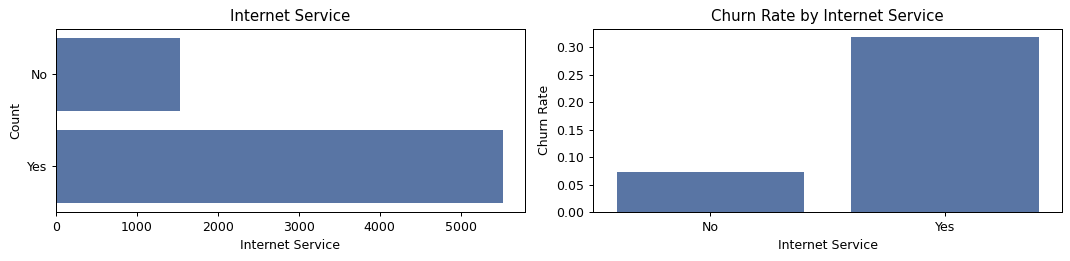

In [72]:
plot_var('Internet Service', 'Internet Service', False)

In [73]:
df.groupby('Internet Service')['Churn'].value_counts(normalize=True)

Internet Service  Churn
No                No       0.925950
                  Yes      0.074050
Yes               No       0.681711
                  Yes      0.318289
Name: proportion, dtype: float64

#### 24. Internet Type

- Fiber Optic: Represents customers who use Fiber Optic
- DSL: Represents customers who use DSL
- No Internet: Represents customers who do not have Internet Service
- Cable: Represents customers who use Cable

In [74]:
df['Internet Type'].value_counts()

Internet Type
Fiber Optic    3035
DSL            1652
No Internet    1526
Cable           830
Name: count, dtype: int64

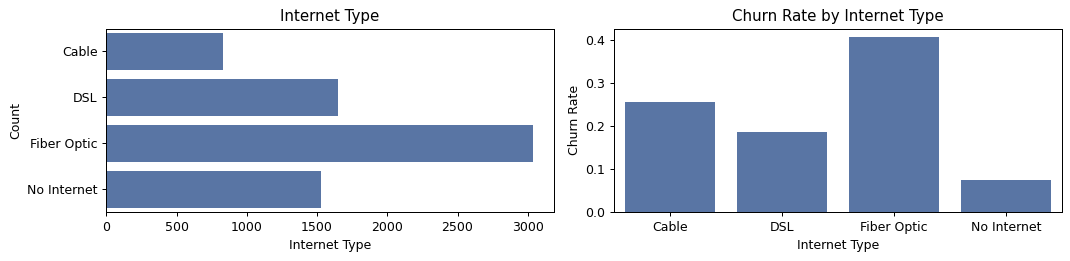

In [75]:
plot_var('Internet Type', 'Internet Type', False)

#### 25. Avg Monthly GB Download

This represents the average monthly GB download used by the customer

In [76]:
df['Avg Monthly GB Download'].describe()

count    7043.000000
mean       20.515405
std        20.418940
min         0.000000
25%         3.000000
50%        17.000000
75%        27.000000
max        85.000000
Name: Avg Monthly GB Download, dtype: float64

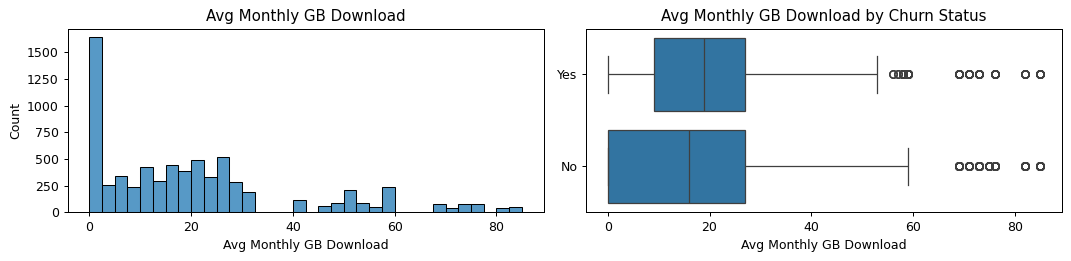

In [77]:
plot_var('Avg Monthly GB Download', 'Avg Monthly GB Download', True)

#### 26. Online Security

- Yes: The customer uses the Online Security Service
- No: The customer does ust the Online Security Service

In [78]:
df['Online Security'].value_counts()

Online Security
No     5024
Yes    2019
Name: count, dtype: int64

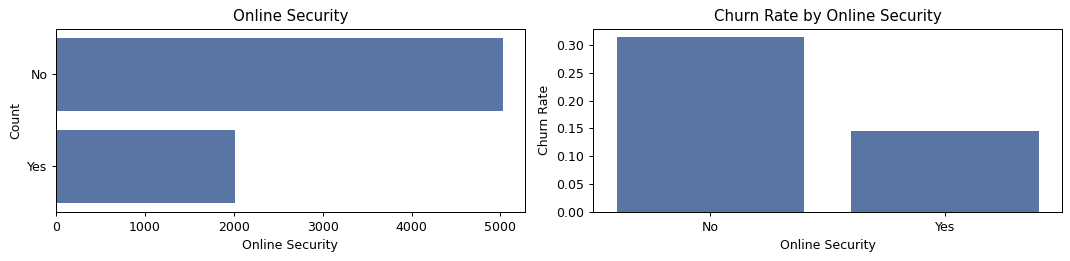

In [79]:
plot_var('Online Security', 'Online Security', False)

#### 27. Online Backup

- No: Represents customers who do not have Online Backup
- Yes: Represents customers who do have an Online Backup

In [80]:
df['Online Backup'].value_counts()

Online Backup
No     4614
Yes    2429
Name: count, dtype: int64

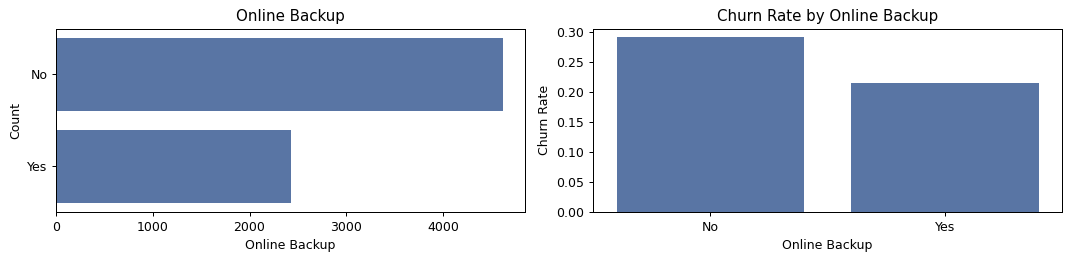

In [81]:
plot_var('Online Backup', 'Online Backup', False)

#### 28. Device Protection Plan

- Yes: Represents customers that have have device protection
- No: Represents customers that do not have device protection

In [82]:
df['Device Protection Plan'].value_counts()

Device Protection Plan
No     4621
Yes    2422
Name: count, dtype: int64

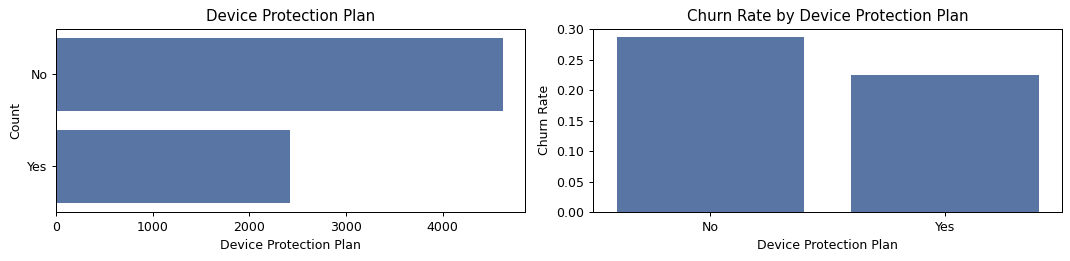

In [83]:
plot_var('Device Protection Plan', 'Device Protection Plan', False)

#### 29. Premium Tech Support

- Yes: Customers who have tech support services
- No: Customers who do not have tech support services

In [84]:
df['Premium Tech Support'].value_counts()

Premium Tech Support
No     4999
Yes    2044
Name: count, dtype: int64

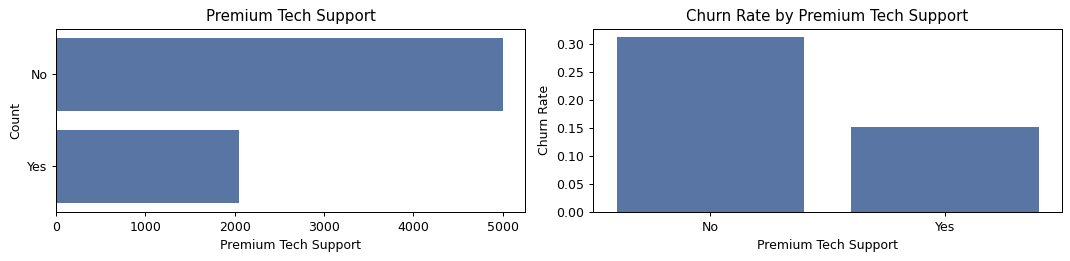

In [85]:
plot_var('Premium Tech Support', 'Premium Tech Support', False)

#### 30. StreamingTV

- Yes: Customers who have Streaming TV services
- No: Customers who do not have Streaming TV services
- No internet service: Customers who do not have any internet services

In [86]:
df['Streaming TV'].value_counts()

Streaming TV
No     4336
Yes    2707
Name: count, dtype: int64

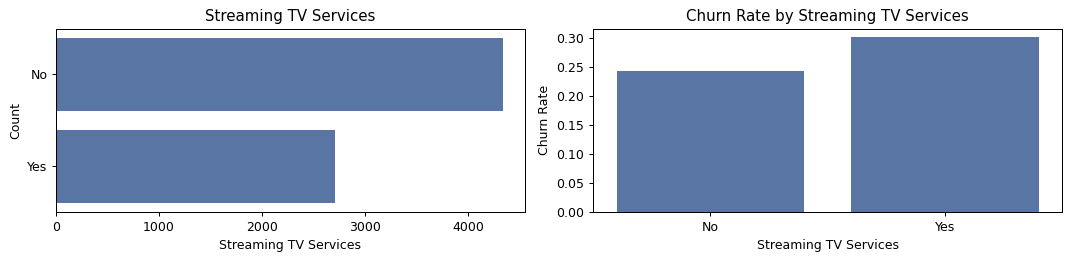

In [87]:
plot_var('Streaming TV', 'Streaming TV Services', False)

In [88]:
df.groupby('Streaming TV')['Churn'].value_counts(normalize=True)

Streaming TV  Churn
No            No       0.756688
              Yes      0.243312
Yes           No       0.699298
              Yes      0.300702
Name: proportion, dtype: float64

#### 31. Streaming Movies

- Yes: Represents customers who have Streaming Movie services
- No: Represents customers who do not have Streaming Movie services

In [89]:
df['Streaming Movies'].value_counts()

Streaming Movies
No     4311
Yes    2732
Name: count, dtype: int64

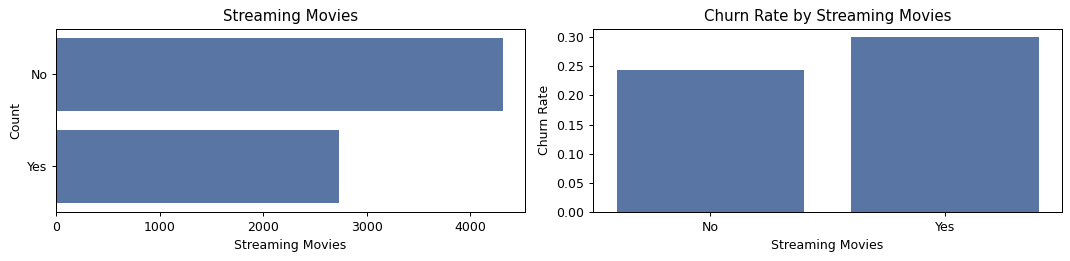

In [90]:
plot_var('Streaming Movies', 'Streaming Movies', False)

#### 32. Streaming Music

- Yes: Represents that the customer has streaming music services
- No: Represents that the customer does not have streaming music services

In [91]:
df['Streaming Music'].value_counts()

Streaming Music
No     4555
Yes    2488
Name: count, dtype: int64

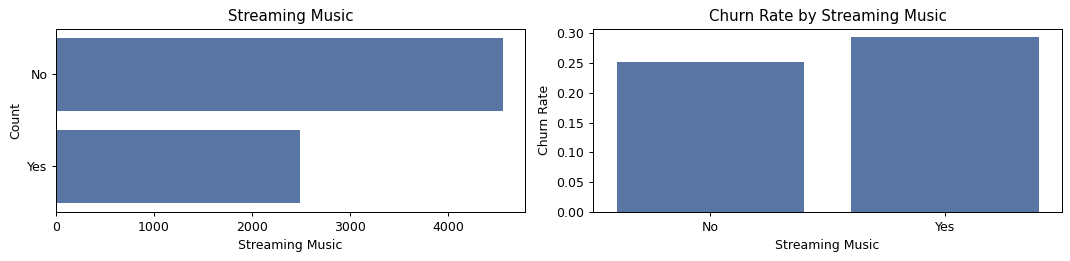

In [92]:
plot_var('Streaming Music', 'Streaming Music', False)

#### 33. Unlimited Data

- Yes: Reprsents customers who unlimited data
- No: Represents customers who have limited data plans

In [93]:
df['Unlimited Data'].value_counts()

Unlimited Data
Yes    4745
No     2298
Name: count, dtype: int64

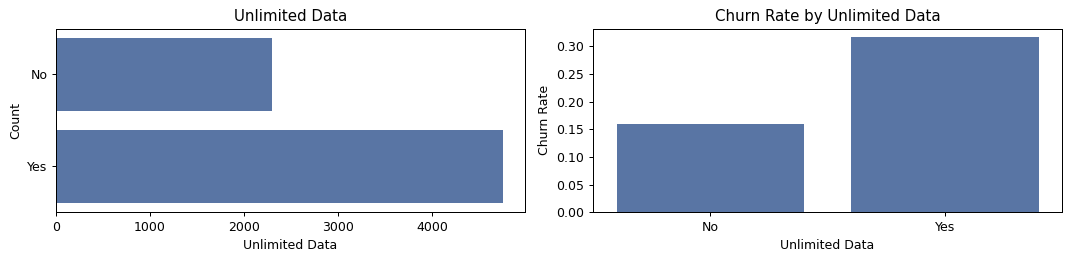

In [94]:
plot_var('Unlimited Data', 'Unlimited Data', False)

#### 34. Contract

- Month-to-month: Represents customers who have a monthly subscription service
- Two year: Represents customers who have a contract for 2 years
- One year: Represents customers who have a contract for 1 year

In [95]:
df['Contract'].value_counts(normalize=True)

Contract
Month-to-Month    0.512566
Two Year          0.267358
One Year          0.220077
Name: proportion, dtype: float64

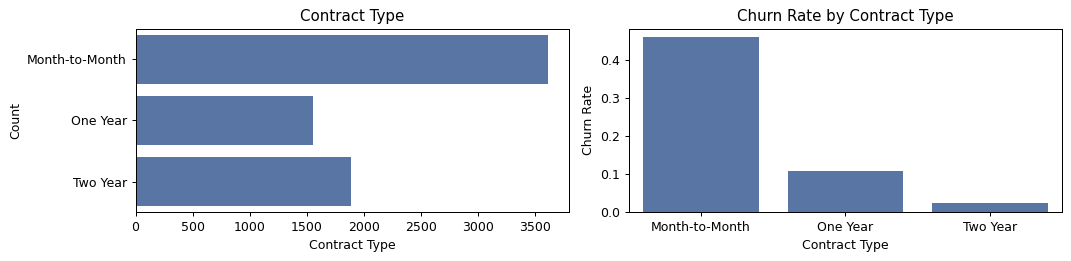

In [96]:
plot_var('Contract', 'Contract Type', False)

In [97]:
df.groupby('Contract')['Churn'].value_counts(normalize=True)

Contract        Churn
Month-to-Month  No       0.541551
                Yes      0.458449
One Year        No       0.892903
                Yes      0.107097
Two Year        No       0.974509
                Yes      0.025491
Name: proportion, dtype: float64

Month-to-month subscription services churn the most proportionally throuhgout the dataset. This makes intutive sense as customers who are monthly can decide to quit this service for a competitor or whatever various reason they choose to leave.

**Note**: Month-to-month customers represent over half the dataset, so this could also lead to higher volume of churn proportional to alternative contract types. 

#### 35. Paperless Billing

- Yes: Represents the customers who use PaperlessBilling
- No: Represents the customers who do not use PaperlessBilling

In [98]:
df['Paperless Billing'].value_counts(normalize=True)

Paperless Billing
Yes    0.592219
No     0.407781
Name: proportion, dtype: float64

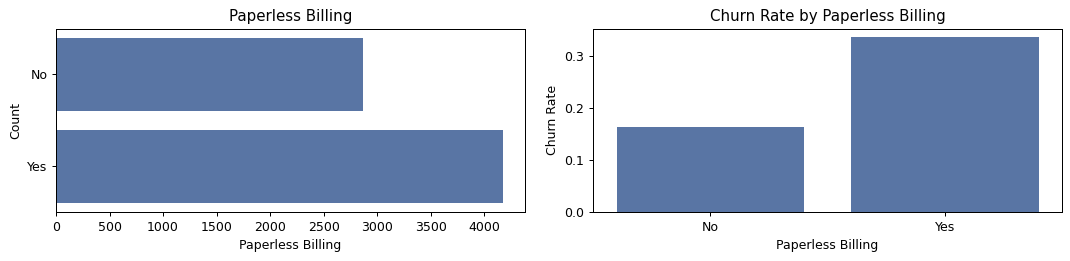

In [99]:
plot_var('Paperless Billing', 'Paperless Billing', False)

In [100]:
df.groupby('Paperless Billing')['Churn'].value_counts(normalize=True)

Paperless Billing  Churn
No                 No       0.836699
                   Yes      0.163301
Yes                No       0.664349
                   Yes      0.335651
Name: proportion, dtype: float64

Customers who use Paperless Billing tend to churn more oftent than those that do not participate in Paperless Billing.

#### 36. Payment Method

- Electronic check: Customers who choose to pay via Electronic check
- Mailed check: Customers who choose to pay via Mailed check
- Bank transfer (automatic): Customers who choose to pay via Bank Transfer (automatic)
- Credit card (automatic): Customers who choose to pay via Credit card (automatic)

In [101]:
df['Payment Method'].value_counts(normalize=True)

Payment Method
Bank Withdrawal    0.555019
Credit Card        0.390317
Mailed Check       0.054664
Name: proportion, dtype: float64

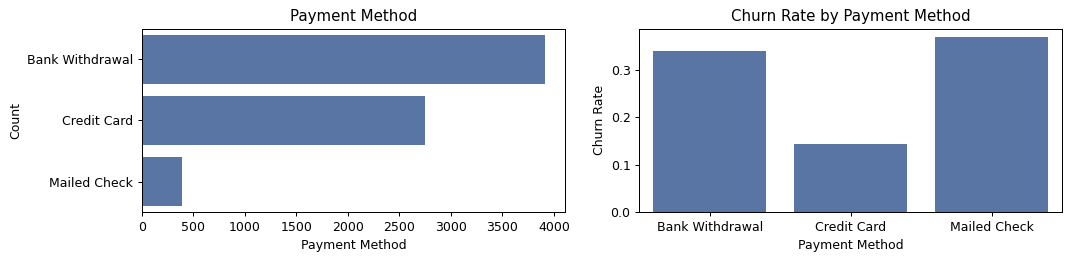

In [102]:
plot_var('Payment Method', 'Payment Method', False)

In [103]:
df.groupby('Payment Method')['Churn'].value_counts(normalize=True)

Payment Method   Churn
Bank Withdrawal  No       0.660015
                 Yes      0.339985
Credit Card      No       0.855220
                 Yes      0.144780
Mailed Check     No       0.631169
                 Yes      0.368831
Name: proportion, dtype: float64

#### 37. Monthly Charges

Represents the monthly charges a customer incurs

In [104]:
df['Monthly Charge'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: Monthly Charge, dtype: float64

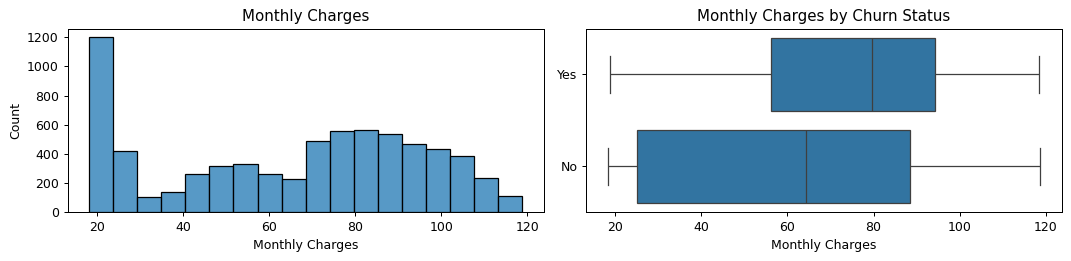

In [105]:
plot_var('Monthly Charge', 'Monthly Charges', True)

In [106]:
df.groupby('Churn')['Monthly Charge'].describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75
Yes,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35


Customers who incure highly Monthly Charges tend to churn more often than customers who pay less monthly. 

#### 38. Total Charges

The sum total charges that the customer has paid since being onboarded. 

In [107]:
df['Total Charges'].describe()

count    7043.000000
mean     2280.381264
std      2266.220462
min        18.800000
25%       400.150000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: Total Charges, dtype: float64

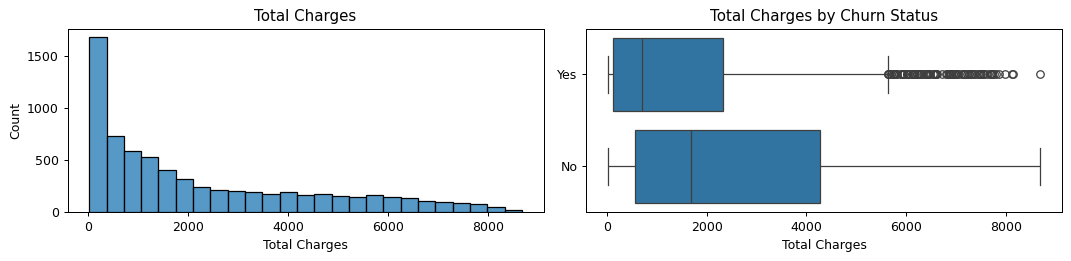

In [108]:
plot_var('Total Charges', 'Total Charges', True)

In [109]:
df.groupby('Churn')['Total Charges'].describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,2550.792103,2329.091754,18.80,574.3875,1679.525,4262.85,8672.45
Yes,1869.0,1531.796094,1890.822994,18.85,134.5000,703.550,2331.30,8684.80


Customers who churn actually pay less in TotalCharges than cusomters who do not churn. This is the case because tenure plays a role in TotalCharges. The longer the customer stays, the more money they will pay over that time. Since they stay longer, this also results in less churn. 

**Note** The distribution of Churn versus non-Churn customers are exactly the same count as the MonthlyCharges.

#### 39. Total Refunds

The total refunds a customer has received since being onboarded.

In [110]:
df['Total Refunds'].describe()

count    7043.000000
mean        1.962182
std         7.902614
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        49.790000
Name: Total Refunds, dtype: float64

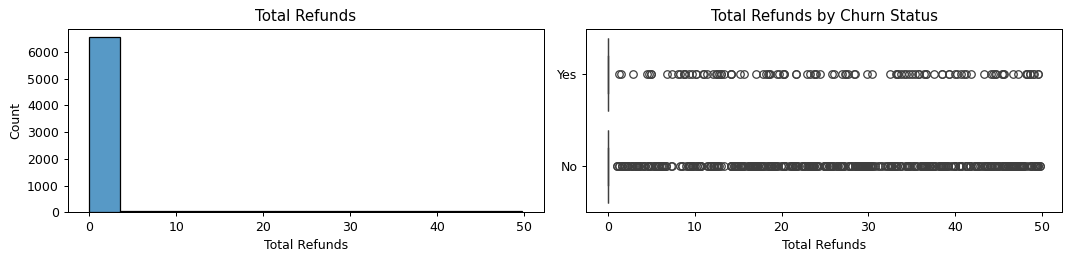

In [111]:
plot_var('Total Refunds', 'Total Refunds', True)

When looking at the charts above it seems that refunds are very spread out and the distribution will be hard to work with. To correct this, I will take the natural logarithm of the "Total Refunds" column.

In [112]:
df['Log Total Refunds'] = df['Total Refunds'].apply(lambda x: np.log10(x+1))

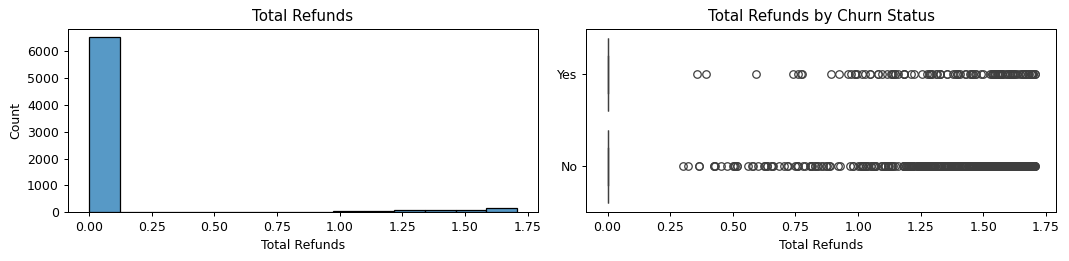

In [113]:
plot_var('Log Total Refunds', 'Total Refunds', True)

In [114]:
df.drop(columns='Total Refunds', inplace=True)

#### 40. Total Extra Data Charges

Total extra data charges incurred by each customer

In [115]:
df['Total Extra Data Charges'].value_counts()

Total Extra Data Charges
0      6315
10      138
40       62
30       58
20       51
80       47
100      44
50       43
150      42
130      40
140      38
60       36
90       35
70       34
110      32
120      28
Name: count, dtype: int64

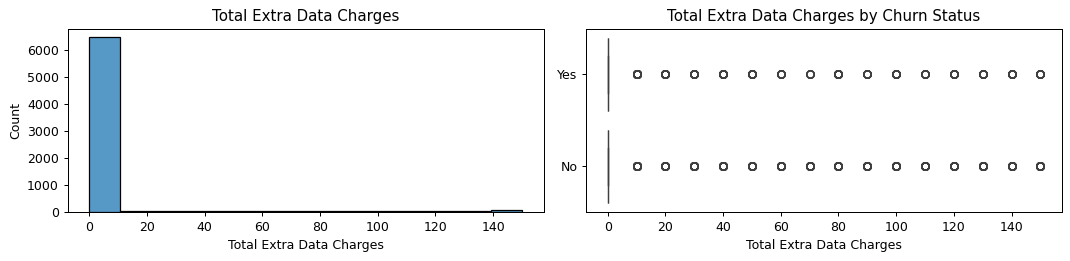

In [116]:
plot_var('Total Extra Data Charges', 'Total Extra Data Charges', True)

The distribution is far too spread out meaning that we need to transform this variable with the natural logarithm. 

In [117]:
df['Log Total Extra Data Charges'] = df['Total Extra Data Charges'].apply(lambda x: np.log10(x+1))

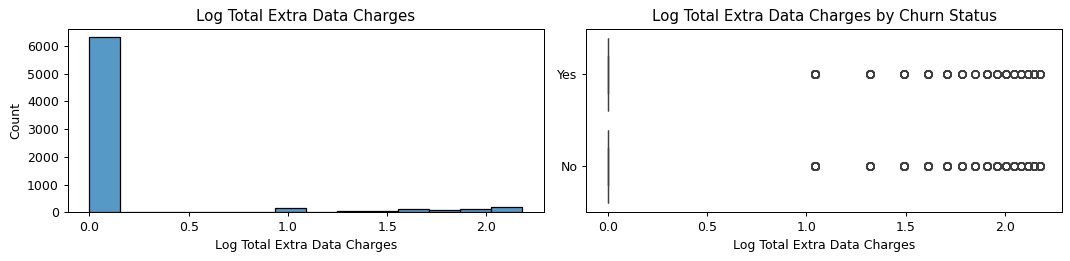

In [118]:
plot_var('Log Total Extra Data Charges', 'Log Total Extra Data Charges', True)

In [119]:
df.drop(columns='Total Extra Data Charges', inplace=True)

#### 41. Total Long Distance Charges

The total charges that a customer incurs due to long distance since being onboarded.

In [120]:
df['Total Long Distance Charges'].describe()

count    7043.000000
mean      749.099262
std       846.660055
min         0.000000
25%        70.545000
50%       401.440000
75%      1191.100000
max      3564.720000
Name: Total Long Distance Charges, dtype: float64

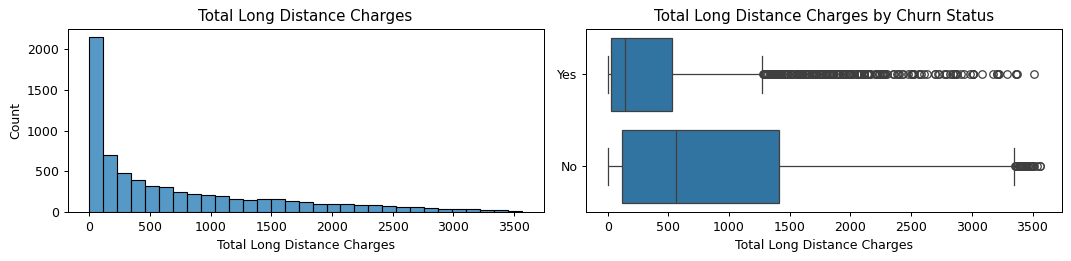

In [121]:
plot_var('Total Long Distance Charges', 'Total Long Distance Charges', True)

#### 42. Total Revenue

Total revenue generated from all charges made from charging each customer

In [122]:
df['Total Revenue'].describe()

count     7043.000000
mean      3034.379056
std       2865.204542
min         21.360000
25%        605.610000
50%       2108.640000
75%       4801.145000
max      11979.340000
Name: Total Revenue, dtype: float64

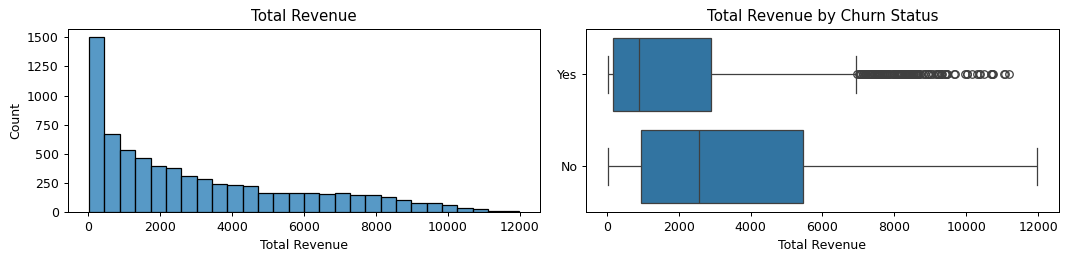

In [123]:
plot_var('Total Revenue', 'Total Revenue', True)

#### 43. Satisfaction Score

Represents a score of how satisfied the customer has been with our services. 1 being the worst and 5 being the best. 

Currently, this feature is represented as an integer value. We need to convert this to category.

In [124]:
df['Satisfaction Score'] = df['Satisfaction Score'].astype('category')

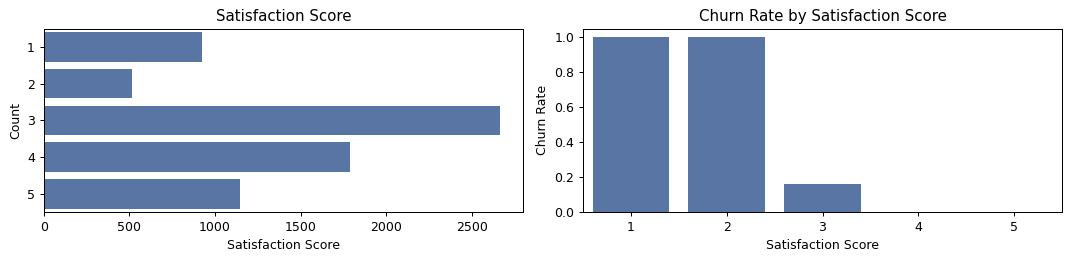

In [125]:
plot_var('Satisfaction Score', 'Satisfaction Score', False)

#### 44. Customer Status

This represents if customers stayed, joined, or churned. 

In [126]:
df['Customer Status'].value_counts()

Customer Status
Stayed     4720
Churned    1869
Joined      454
Name: count, dtype: int64

This column is essentially another column to determine churn. We can remove this column as we already have a "Churn" column designating customers as churn or not. 

In [127]:
df.drop(columns='Customer Status', inplace=True)

#### 45. Churn Score

This column appears to be a score from a previous model. Therefore, we will drop this column from the dataset. 

In [128]:
df['Churn Score'].describe()

count    7043.000000
mean       58.505040
std        21.170031
min         5.000000
25%        40.000000
50%        61.000000
75%        75.500000
max        96.000000
Name: Churn Score, dtype: float64

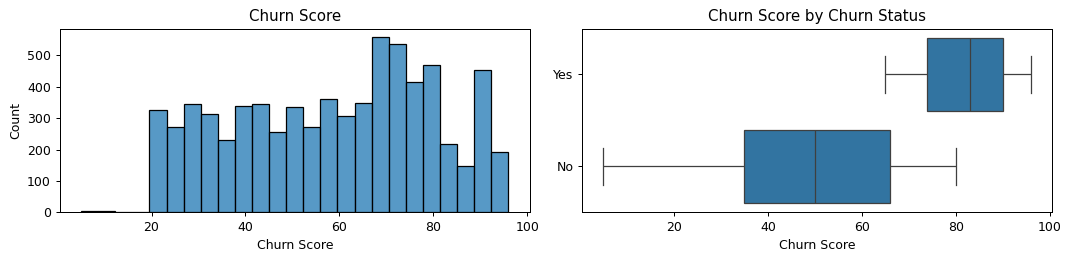

In [129]:
plot_var('Churn Score', 'Churn Score', True)

In [130]:
df.drop(columns='Churn Score', inplace=True)

#### 46. CLTV (Customer Lifetime Value)

This represents the potential revenue that will be generated from keeping each customer over their lifetime as a customer.

This will be unnecessary for prediction.

In [131]:
df['CLTV'].describe()

count    7043.000000
mean     4400.295755
std      1183.057152
min      2003.000000
25%      3469.000000
50%      4527.000000
75%      5380.500000
max      6500.000000
Name: CLTV, dtype: float64

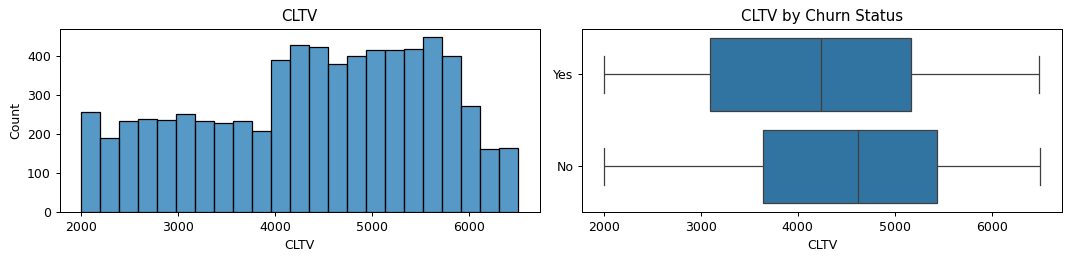

In [132]:
plot_var('CLTV', 'CLTV', True)

In [133]:
df.drop(columns='CLTV', inplace=True)

#### 47. Churn Category

Represents the category of why a customer churned. Keeping this feature would allow data leakage. This would of course be great for predicting customer churn but woudn't be known at the time the customer is onboarded.

In [134]:
df['Churn Category'].value_counts()

Churn Category
No Churn           5174
Competitor          841
Attitude            314
Dissatisfaction     303
Price               211
Other               200
Name: count, dtype: int64

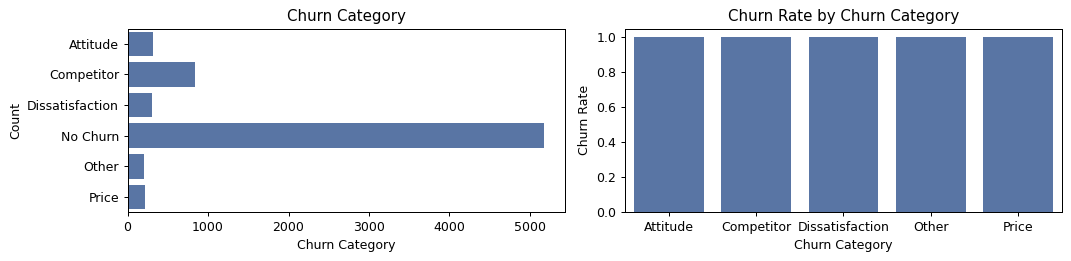

In [135]:
plot_var('Churn Category', 'Churn Category', False)

In [136]:
df.drop(columns='Churn Category', inplace=True)

#### 48. Churn Reason

This represents the reason a customer churned. We need to drop this column from the dataset. 

In [137]:
df.drop(columns='Churn Reason', inplace=True)

#### 49. Churn

Labled data that reflects if a customer churned or not. This is a response variable.

In [138]:
df['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

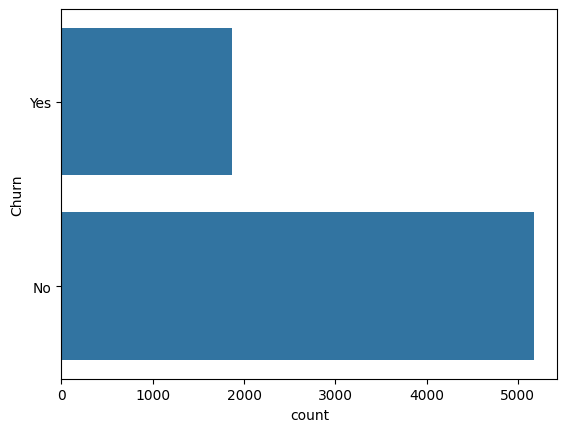

In [139]:
sns.countplot(df['Churn'])
plt.show()

This dataset is comprised of approximately 73% No Churn and the remaining as Churn. This is very unbalanced which means our models will be very good at predicted No Churn. Consequently, our models should be pretty good at predicting Churn as this is a binary outcome. 

#### Convert all object data types into categorical for better data frame management

In [140]:
for col in df.columns: 
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')
    

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Gender                             7043 non-null   category
 1   Age                                7043 non-null   int64   
 2   Under 30                           7043 non-null   category
 3   Senior Citizen                     7043 non-null   category
 4   Married                            7043 non-null   category
 5   Dependents                         7043 non-null   category
 6   Number of Dependents               7043 non-null   category
 7   City                               7043 non-null   category
 8   Population                         7043 non-null   int64   
 9   Referred a Friend                  7043 non-null   category
 10  Number of Referrals                7043 non-null   category
 11  Tenure in Months                   7043 non

# Preparing Data for Machine Learning Models

In [142]:
churn = df.copy()
churn = np.where(churn['Churn'] == 'Yes', 1, 0)
churn

array([1, 1, 1, ..., 0, 0, 0])

In [143]:
# Separate features and target
X = df.drop(columns='Churn')
y = churn

We want to view the columns we are using one last time before implementing them in the machine learning models to ensure we aren't including columns that shouldn't be there. 

In [144]:
X.columns

Index(['Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married', 'Dependents',
       'Number of Dependents', 'City', 'Population', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges',
       'Total Long Distance Charges', 'Total Revenue', 'Satisfaction Score',
       'Log Total Refunds', 'Log Total Extra Data Charges'],
      dtype='object')

In [145]:
# One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True, dtype=int)

In [146]:
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (7043, 1170)
y Shape: (7043,)


In [147]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Train Dataset Shape:")
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"\nTest Dataset Shape:")
print(f"X_test Shape:  {X_test.shape}")
print(f"y_test Shape:  {y_test.shape}")

Train Dataset Shape:
X_train Shape: (4930, 1170)
y_train Shape: (4930,)

Test Dataset Shape:
X_test Shape:  (2113, 1170)
y_test Shape:  (2113,)


The stratify=y parameter helps to maintain the same proportion of the target variable (Churn) in both the training and test sets.

In [148]:
# Initialize scaler
scaler = StandardScaler()

# Fit only on the training set to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [149]:
X_train_scaled

array([[-0.92311922,  0.35902018,  1.28210997, ...,  1.29141353,
        -0.5853141 , -0.44503471],
       [ 0.62329488, -0.1765183 , -1.27844955, ...,  1.29141353,
        -0.5853141 , -0.44503471],
       [ 1.03963714,  0.60490981, -1.27844955, ..., -0.7743453 ,
        -0.5853141 , -0.44503471],
       ...,
       [ 0.08799769, -1.03098954, -0.54686112, ...,  1.29141353,
        -0.5853141 , -0.44503471],
       [ 0.86120475,  0.20245838, -0.91265533, ...,  1.29141353,
        -0.5853141 , -0.44503471],
       [ 0.44486249,  2.22709572, -0.70943632, ...,  1.29141353,
        -0.5853141 , -0.44503471]])

# Classification Models

#### Most of the structure of this section is inspired by the following Kaggle Notebook:

#### https://www.kaggle.com/code/ahmedashrafahmed/customer-churn-prediction-eda-and-model-98-acc#notebook-container

## Baseline Model Accuracy

Summary and Model Explanation

Here’s a brief overview of each model:

1.	RandomForest: A robust model that builds multiple decision trees and combines their results. It’s usually strong for many datasets because it reduces the risk of overfitting on training data.
2.	XGBoost (Extreme Gradient Boosting): A boosting algorithm that sequentially improves weak models, typically strong for structured/tabular data but requires specific libraries (like libomp) for optimal performance.
3.	LGBM (LightGBM): Similar to XGBoost, this model builds trees for faster and efficient boosting. It’s often faster on larger datasets.
4.	DecisionTree: A simpler model that makes decisions based on if-else rules. It can overfit easily, meaning it may not perform as well on new data.
5.	KNN (K-Nearest Neighbors): A non-parametric model that classifies data based on the most common class among nearest neighbors. KNN is sensitive to how data is scaled.
6.	SVC (Support Vector Classifier): This model tries to find the best boundary between classes. It performs better with fewer features and requires careful parameter tuning.
7.	LogisticRegression: A basic model for binary classification that calculates probabilities for each class. Scaling data and more iterations often help improve its convergence.
8.	CatBoost: Another boosting model specifically optimized for categorical features, which is why it’s performing well.
9.	GradientBoosting and AdaBoost: Both are boosting methods that correct errors from weaker models by adjusting weights or modifying the input data. They’re generally strong choices, particularly for structured data.
10.	NaiveBayes: A probabilistic model often used for text classification. It’s less complex but works well for certain types of data.


In [150]:
models = {
    'LogisticRegression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=10000),
}
### Validation Score
cv_results = {}
for model_name, model in models.items():
    print(f"Cross-validating {model_name}...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
    cv_results[model_name] = cv_scores.mean()
    print(f"Mean accuracy for {model_name}: {cv_scores.mean():.4f}")

Cross-validating LogisticRegression...
Mean accuracy for LogisticRegression: 0.9241


As can be seen from the above average accuracy for each model, the MLP model outperforms.

In [151]:
cv_results_df = pd.DataFrame(list(cv_results.items()), columns=['Model', 'Mean Accuracy'])
cv_results_df = cv_results_df.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)
cv_results_df

,Model,Mean Accuracy
0,LogisticRegression,0.924138


In [152]:
best_model_name = cv_results_df.iloc[0]['Model']
print(f"\nBest model from CV: {best_model_name}")


Best model from CV: LogisticRegression


## Optimizing Parameters for Best Cross-Validation Score

##### This next cell takes approximately 12 minutes to run.

### Parameter Grid Explanation for Logistic Regression

In the `param_grids` dictionary, we define the hyperparameters that will be tuned using `GridSearchCV` for the `LogisticRegression` model. Below is a detailed explanation of each parameter:

- **`C`**: This parameter represents the inverse of regularization strength. It controls the amount of regularization applied to the model. A smaller value of `C` implies stronger regularization, which can prevent overfitting but may lead to underfitting if too small. The values in the grid `[0.01, 0.1, 1, 10]` are chosen to test different levels of regularization:
  - `0.01`: High regularization (strong penalty)
  - `0.1`: Moderate regularization
  - `1`: Default value (no additional regularization)
  - `10`: Low regularization (weak penalty)

- **`penalty`**: This parameter specifies the type of regularization used in the model. The options included are:
  - `'l1'`: L1 regularization, which adds a penalty equal to the absolute value of the magnitude of coefficients. This can lead to sparse solutions (some coefficients may become zero).
  - `'l2'`: L2 regularization, which adds a penalty equal to the square of the magnitude of coefficients. This helps distribute errors uniformly across all coefficients and is more commonly used than L1.

- **`solver`**: This parameter determines the algorithm used to optimize the loss function. The options are:
  - `'liblinear'`: A good choice for smaller datasets and supports L1 and L2 regularization. It works well with `penalty='l1'` and `penalty='l2'`.
  - `'saga'`: An extension of the `sag` solver that supports both L1 and L2 regularization. It is suitable for large-scale datasets and is capable of handling the `penalty='l1'`.

By setting up a grid with these combinations, `GridSearchCV` will perform cross-validation to determine which combination of `C`, `penalty`, and `solver` yields the best model performance based on the chosen scoring metric (`accuracy` in this case).

In [153]:
param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
}

best_results = []

# Existing model tuning with GridSearchCV
for model_name, model in models.items():
        print(f"\nPerforming GridSearchCV for {model_name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_results.append({'Model': model_name, 'Best Score': best_score, 'Best Params': best_params})
        print(f"Best parameters for {model_name}: {best_params}")
        print(f"Best cross-validation score for {model_name}: {best_score:.4f}")


Performing GridSearchCV for LogisticRegression...
Best parameters for LogisticRegression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score for LogisticRegression: 0.9580


In [154]:
best_results_df = pd.DataFrame(best_results)
best_results_df = best_results_df.sort_values(by='Best Score', ascending=False)
best_results_df

,Model,Best Score,Best Params
0,LogisticRegression,0.958012,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}"


In [155]:
best_model_name, best_model_param = best_results_df.iloc[0]['Model'], best_results_df.iloc[0]['Best Params']
print(f"\nBest model : {best_model_name}")
print(f"\nBest Parameters : {best_model_param}")


Best model : LogisticRegression

Best Parameters : {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [156]:
best_model_param

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

## Evaluating Best Model

In [ ]:
# Cross Validation Parameters
cv_parameters = {"C":np.logspace(0, 10, num=20)}

# Logistic Regression Model
logistic_regression_model = LogisticRegression(C=10, penalty='l1', solver='liblinear')

# Beginning Cross Validation
cv_model = GridSearchCV(logistic_regression_model, cv_parameters, scoring='accuracy')
start_time = time.time()
cv_model.fit(X_train, y_train)
end_time = time.time()

# Determining the best model
best_model = cv_model.best_estimator_
print("=========================================================")
print("  Model: L1 Penalized Logistic Regression")
print("=========================================================")
print(f"Fit time: {str(round(end_time - start_time, 2))} seconds")
print("Optimal parameters:")
print(f'cv_model.best_params_\n')

# Make predictions on the test and establish ROC Curve
y_pred_probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Make predictions; if we were able to find probabilities, use
# the threshold that maximizes the accuracy in the training set.
y_train_pred_probs = best_model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)

true_pos_train = tpr_train * (y_train.sum())
true_neg_train = (1 - fpr_train) * (1 - y_train).sum()

best_threshold_index = np.argmax(true_pos_train + true_neg_train)
best_threshold = 1 if best_threshold_index == 0 else thresholds_train[best_threshold_index]

print(f'Accuracy-Maximizing Threshold: {str(best_threshold)}')

y_train_preds = (y_train_pred_probs > best_threshold)
y_pred = (y_pred_probs > best_threshold)
print()
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn'], digits=4))


  Model: Logistic Regression
Fit time: 11.74 seconds
Optimal parameters:
cv_model.best_params_

Accuracy-Maximizing Threshold: 0.5602882637079917

Accuracy: 0.9597728348319924
              precision    recall  f1-score   support

    No Churn     0.9582    0.9884    0.9730      1552
       Churn     0.9648    0.8806    0.9208       561

    accuracy                         0.9598      2113
   macro avg     0.9615    0.9345    0.9469      2113
weighted avg     0.9599    0.9598    0.9592      2113



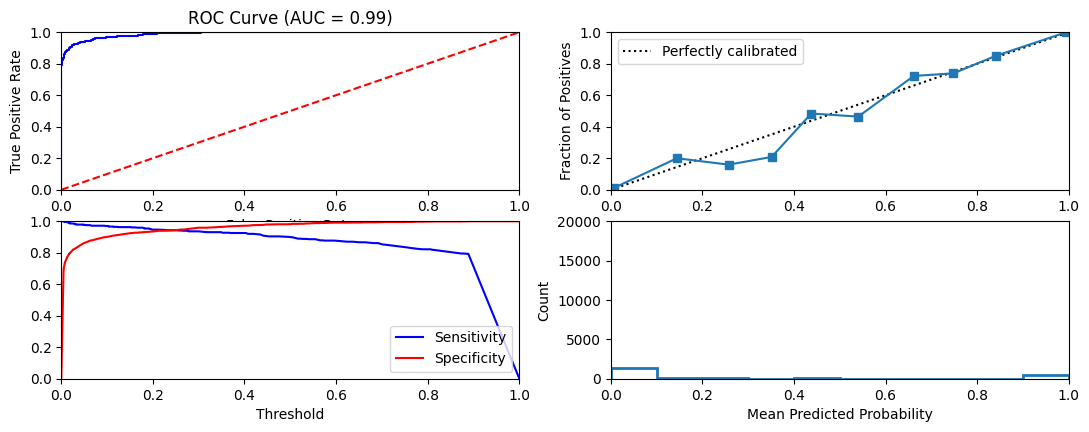

In [186]:
plt.figure(figsize = (13, 4.5))

plt.subplot(2, 2, 1)

plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(2, 2, 3)

plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
plt.legend(loc = 'lower right')
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel('Threshold')

plt.subplot(2, 2, 2)

fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
plt.plot(mpv_0, fp_0, 's-')
plt.ylabel('Fraction of Positives')
plt.xlim([0,1]); plt.ylim([0,1])
plt.legend(loc ='upper left')

plt.subplot(2, 2, 4)

plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
plt.xlim([0,1]); plt.ylim([0,20000])
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Count')

plt.show()

In [187]:
y_pred

array([ True, False,  True, ..., False, False, False])

Confusion Matrix:
 [[1534   18]
 [  67  494]]


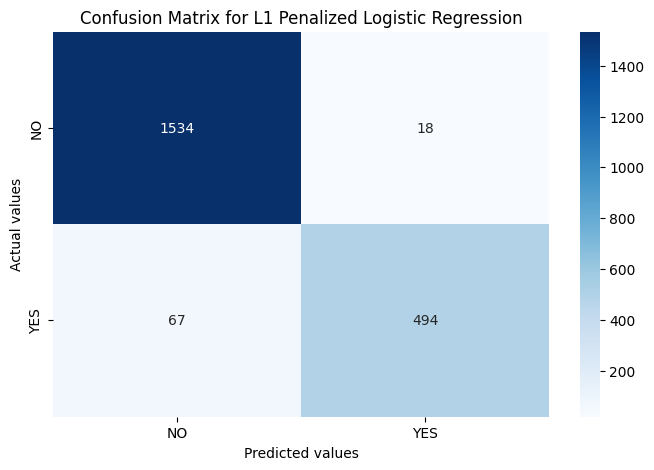

In [218]:
# Confusion Matrix for test set
cm = confusion_matrix(y_test, y_pred=y_pred)
print('Confusion Matrix:\n', cm)
plt.figure(figsize=(8, 5))
sns.heatmap(data=cm, annot=True, fmt='g', cmap="Blues", xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for L1 Penalized Logistic Regression')
plt.show()

In [189]:
X.columns

Index(['Age', 'Population', 'Tenure in Months',
       'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
       'Monthly Charge', 'Total Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Log Total Refunds',
       ...
       'Unlimited Data_Yes', 'Contract_One Year', 'Contract_Two Year',
       'Paperless Billing_Yes', 'Payment Method_Credit Card',
       'Payment Method_Mailed Check', 'Satisfaction Score_2',
       'Satisfaction Score_3', 'Satisfaction Score_4', 'Satisfaction Score_5'],
      dtype='object', length=1170)

In [190]:
# Extracting the top and bottom index row numbers
top_and_bottom_idx = list(np.argsort(best_model.coef_)[0, :5]) + list(np.argsort(best_model.coef_)[0, -5:])
top_and_bottom_idx

[1169, 1168, 1167, 1153, 1162, 1142, 133, 1149, 1152, 1131]

In [191]:
# Extracing the values based on the index rows
bplot = pd.Series(best_model.coef_[0, top_and_bottom_idx])
bplot

0   -13.558598
1   -13.480230
2    -7.836257
3    -2.702270
4    -1.571958
5     1.655683
6     1.940769
7     2.062518
8     2.431828
9     2.970975
dtype: float64

In [192]:
# Extracting the features based on the highest and lowest coefficients indexes 
xticks = X_train.columns[top_and_bottom_idx]
xticks

Index(['Satisfaction Score_5', 'Satisfaction Score_4', 'Satisfaction Score_3',
       'Online Security_Yes', 'Contract_Two Year', 'Offer_Offer A',
       'City_Brea', 'Internet Service_Yes', 'Internet Type_No Internet',
       'Number of Referrals_1'],
      dtype='object')

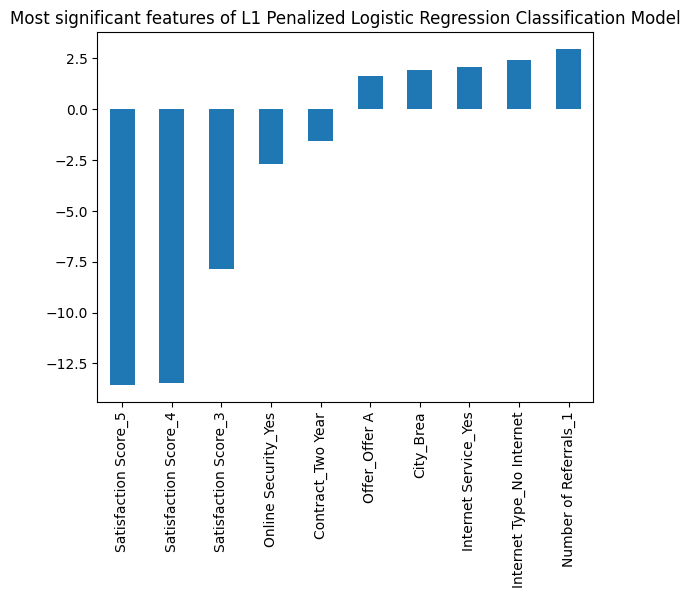

In [219]:
## plot top 3 features with the most positive (and negative) weights 
p1 = bplot.plot(kind='bar',rot=90)
p1.set_xticklabels(xticks)
plt.title('Most significant features of L1 Penalized Logistic Regression Classification Model')
plt.show()

In [194]:
# Calculate metrics for training data
train_accuracy = accuracy_score(y_train, y_train_preds)
train_precision = precision_score(y_train, y_train_preds)
train_recall = recall_score(y_train, y_train_preds)
train_f1 = f1_score(y_train, y_train_preds)

# Calculate metrics for test data
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

# Display metrics
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Training Precision: {train_precision:.2f}")
print(f"Training Recall: {train_recall:.2f}")
print(f"Training F1-Score: {train_f1:.2f}")
print("---")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1-Score: {test_f1:.2f}")

metric_df = pd.DataFrame({
    'Training Accuracy':round(train_accuracy, 2),
    'Training Precision':round(train_precision, 2),
    'Training Recall':round(train_recall, 2),
    'Training F1-Score':round(train_f1, 2),
    'Test Accuracy':round(test_accuracy, 2),
    'Test Precision':round(test_precision, 2),
    'Test Recall':round(test_recall, 2),
    'Test F1-Score':round(test_f1, 2)
}, index=[0])

metric_df

Training Accuracy: 0.97
Training Precision: 0.97
Training Recall: 0.91
Training F1-Score: 0.94
---
Test Accuracy: 0.96
Test Precision: 0.96
Test Recall: 0.88
Test F1-Score: 0.92


,Training Accuracy,Training Precision,Training Recall,Training F1-Score,Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,0.97,0.97,0.91,0.94,0.96,0.96,0.88,0.92


# Creating Baseline Churn Rate

We need to create baseline feature conditions to establish a baseline churn rate. The assumption is that Telco would not be operating with a Data Science team to detect and predict churn rates among the current customer base or future customer acquisition.

In [195]:
df['Baseline_Predicted_Churn'] = (
   # Condition 1: Customer has 6 or 7 dependents 
   (df['Number of Dependents'].isin([6, 7])) |
   # Condition 2: Customer is not married and does not have any dependents
   ((df['Married'] == 'No') & (df['Number of Dependents'] == 0)) |
   # Condition 3: Customer uses Fiber Optic
   (df['Internet Type'] == 'Fiber Optic') |
   # Condition 4: Offer 'E' Customer
   (df['Offer'] == 'Offer E') |
   # Condition 5: Customer uses Paperless Billing, Bank Withdrawal, or Mailed Check
   ((df['Paperless Billing'] == 'Yes') & (df['Payment Method'].isin(['Bank Withdrawal', 'Mailed Check']))) |
   # Condition 6: Customer has referred 1 person
   (df['Number of Referrals'] == 1) | 
   # Condition 7: Customer satisfaction score is 1 or 2
   (df['Satisfaction Score'].isin([1, 2])) |
   # Condition 8: Customer is a Senior Citizen
   (df['Senior Citizen'] == 'Yes')
)


In [196]:
df['Baseline_Predicted_Churn'].value_counts()

Baseline_Predicted_Churn
True     5932
False    1111
Name: count, dtype: int64

In [197]:
df['Baseline_Predicted_Churn'] = df['Baseline_Predicted_Churn'].astype(int)

In [198]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [199]:
df.groupby('Baseline_Predicted_Churn')['Churn'].value_counts()

Baseline_Predicted_Churn  Churn
0                         No       1107
                          Yes         4
1                         No       4067
                          Yes      1865
Name: count, dtype: int64

## Creating a Confusion Matrix for Baseline

We want to ensure that the baseline predicted churn is using the same data as the Logistic Regression model to accurately compare the confusion matrices. 

In [209]:
len(y_test)

2113

In [210]:
baseline_df = df.copy()
baseline_df = baseline_df.iloc[-len(y_test):]

In [211]:
len(baseline_df)

2113

In [214]:
# Calculate metrics for test data
test_accuracy_baseline = accuracy_score(y_test, baseline_df['Baseline_Predicted_Churn'])
test_precision_baseline = precision_score(y_test, baseline_df['Baseline_Predicted_Churn'])
test_recall_baseline = recall_score(y_test, baseline_df['Baseline_Predicted_Churn'])
test_f1_baseline = f1_score(y_test, baseline_df['Baseline_Predicted_Churn'])

# Display metrics
print(f"Test Accuracy: {test_accuracy_baseline:.2f}")
print(f"Test Precision: {test_precision_baseline:.2f}")
print(f"Test Recall: {test_recall_baseline:.2f}")
print(f"Test F1-Score: {test_f1_baseline:.2f}")

metric_df_baseline = pd.DataFrame({
    'Test Accuracy':round(test_accuracy_baseline, 2),
    'Test Precision':round(test_precision_baseline, 2),
    'Test Recall':round(test_recall_baseline, 2),
    'Test F1-Score':round(test_f1_baseline, 2)
}, index=[0])

metric_df_baseline

Test Accuracy: 0.37
Test Precision: 0.26
Test Recall: 0.74
Test F1-Score: 0.39


,Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,0.37,0.26,0.74,0.39


Baseline Confusion Matrix:
 [[ 374 1178]
 [ 144  417]]


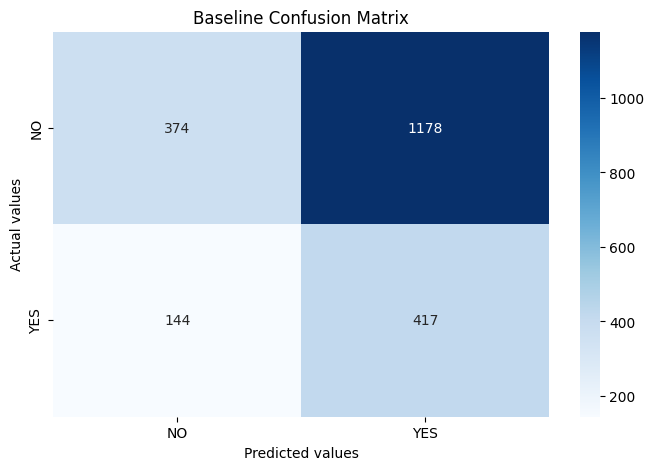

In [217]:
# Confusion Matrix for test set
cm_baseline = confusion_matrix(y_test, baseline_df['Baseline_Predicted_Churn'])
print('Baseline Confusion Matrix:\n', cm_baseline)
plt.figure(figsize=(8, 5))
sns.heatmap(data=cm_baseline, annot=True, fmt='g', cmap="Blues", xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Baseline Confusion Matrix')
plt.show()

# Comparing Our Model to Baseline

In [221]:
test_metric_df = metric_df[['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score']]
test_metric_df

,Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,0.96,0.96,0.88,0.92


In [225]:
comparison_metric_df = pd.concat([test_metric_df, metric_df_baseline]).reset_index(drop=True)

In [226]:
comparison_metric_df

,Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,0.96,0.96,0.88,0.92
1,0.37,0.26,0.74,0.39


In [229]:
comparison_metric_df.rename(index={0:'L1 Penalized Logistic Regression', 1:'Baseline Model'}, inplace=True)

In [230]:
comparison_metric_df

,Test Accuracy,Test Precision,Test Recall,Test F1-Score
L1 Penalized Logistic Regression,0.96,0.96,0.88,0.92
Baseline Model,0.37,0.26,0.74,0.39
